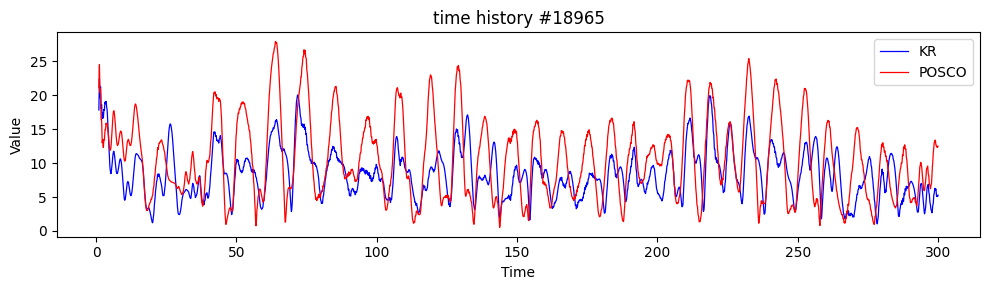

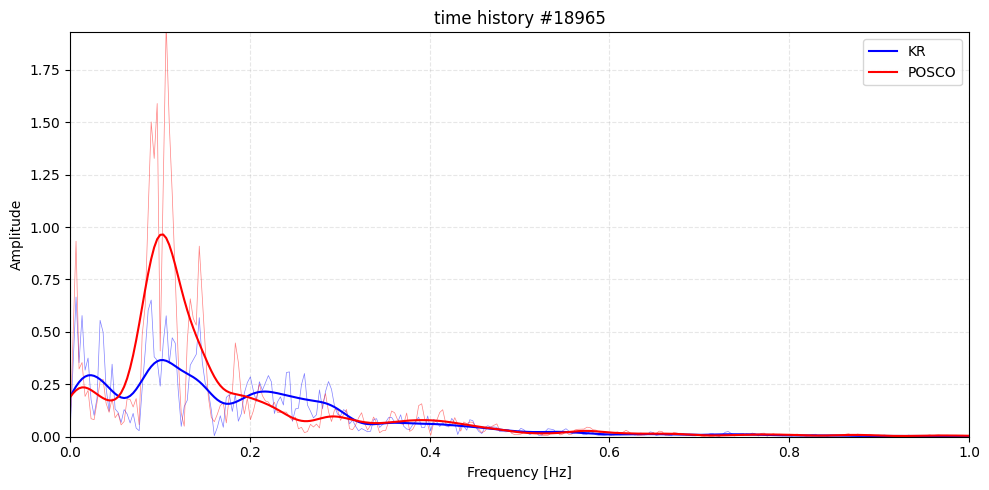

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 0) ASCII 파일 로더
# -------------------------------
def load_time_value_from_ascii(path, encoding="utf-8", tolerance_ratio=0.01):
    t_list, y1_list, y2_list = [], [], []
    title = ""

    with open(path, "r", encoding=encoding, errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith("#") or "time" in line.lower():
                title = line
                continue

            toks = re.split(r"[,\t; ]+", line)
            if len(toks) < 2:
                continue

            try:
                tt = float(toks[0])
                v1 = float(toks[1])
                v2 = float(toks[2]) if len(toks) > 2 else None
            except ValueError:
                continue

            t_list.append(tt)
            y1_list.append(v1)
            y2_list.append(v2 if v2 is not None else np.nan)

    if len(t_list) < 3:
        raise ValueError("유효한 데이터가 3개 미만입니다.")

    t = np.array(t_list)
    y1 = np.array(y1_list)
    y2 = np.array(y2_list)

    # 시간 정렬
    idx = np.argsort(t)
    t, y1, y2 = t[idx], y1[idx], y2[idx]

    # 플롯
    plt.figure(figsize=(10, 3))
    plt.plot(t, y1, linestyle='-', color='blue', label='KR', lw = .9)
    plt.plot(t, y2, linestyle='-', color='red', label='POSCO', lw = .9)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc="best")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    fs, is_uniform, dt_med, dt_std = infer_fs_from_time(t, tolerance_ratio)
    info = {"fs_estimated": fs, "is_uniform": is_uniform, "title": title}
    return t, y1, y2, fs, info

# -------------------------------
# 1) 샘플링 주파수 추정
# -------------------------------
def infer_fs_from_time(t, tolerance_ratio=0.01):
    dt = np.diff(t)
    dt_med = np.median(dt)
    dt_std = np.std(dt)
    fs = 1.0 / dt_med
    return fs, (dt_std / dt_med) < tolerance_ratio, dt_med, dt_std

# -------------------------------
# 2) FFT + 스무딩
# -------------------------------
def fft_amplitude_spectrum(y, fs):
    y = y - np.mean(y)
    N = len(y)
    f = np.fft.rfftfreq(N, 1/fs)
    A = np.abs(np.fft.rfft(y * np.hanning(N))) / N
    A[1:-1] *= 2
    return f, A

def moving_average(x, window=11):
    w = np.ones(window) / window
    return np.convolve(x, w, mode='same')

from scipy.ndimage import gaussian_filter1d

def smooth_gaussian(A, sigma=5.0):
    return gaussian_filter1d(A, sigma=sigma, mode='nearest')

# -------------------------------
# 3) 스펙트럼 계산 및 플롯
# -------------------------------
def compute_and_plot_spectrum(y1, y2, fs, title="Amplitude Spectrum", smooth_factor=40):
    f, A1 = fft_amplitude_spectrum(y1, fs)
    f, A2 = fft_amplitude_spectrum(y2, fs)
    
    #A1_s = moving_average(A1, smooth_factor)
    #A2_s = moving_average(A2, smooth_factor)
    A1_s = smooth_gaussian(A1)
    A2_s = smooth_gaussian(A2)

    plt.figure(figsize=(10, 5))
    plt.plot(f, A1, color='blue', alpha=0.5, lw=.5)  # alpha 투명도
    plt.plot(f, A2, color='red', alpha=0.5, lw=.5)
    plt.plot(f, A1_s, color='blue', label='KR')
    plt.plot(f, A2_s, color='red', label='POSCO')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.xlim(0, 1)
    plt.ylim(0, max(np.max(A1_s), np.max(A2_s)) * 2)
    plt.grid(True, ls='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return f, A1_s, A2_s

# -------------------------------
# 실행 예시
# -------------------------------
if __name__ == "__main__":
    # 파일 읽기
    t, y1, y2, fs, info = load_time_value_from_ascii("your_data_kr.txt")
    # 스펙트럼
    compute_and_plot_spectrum(y1, y2, fs, title=info["title"], smooth_factor=11)
